<p style="text-align:center">
    <a href="https://skills.network" target="_blank">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="200" alt="Skills Network Logo">
    </a>
</p>


# A Transformer Model for Language Translation


## __Table of Contents__

<ol>
    <li><a href="#Objectives">Objectives</a></li>
    <li><a href="#Background">Background</a></li>
    <li><a href="#Setup">Setup</a></li>
    <li><a href="#DataLoader">DataLoader</a></li>
    <li><a href="#Transformer-architecture-for-language-translation">Transformer architecture for language translation</a></li>
    <li><a href="#Training-the-model">Training the model</a></li>
    <li><a href="#Translation-and-evaluation">Translation and evaluation</a></li>
    <li><a href="#Exercise:-Translating-a-document">Exercise: Translating a document</a></li>
</ol>


# Objectives
After completing this lab, you will be able to:

- Describe the transformer architecture
- Build a translation model from scratch using PyTorch:
    - Preprocess textual data
    - Design the transformer architecture
    - Train the model using parallel computing
    - Evaluate the model performance
    - Generate translation
- Translate a PDF document from German to English

# Background
In today’s interconnected world, the ability to break language barriers is more valuable than ever. Whether it's for expanding business reach, accessing information in different languages, or connecting with people across the globe, language translation plays a crucial role. This is where transformer model for language translation lab steps in, letting you delve into the world of neural machine translation – a field at the forefront of overcoming language barriers. You'll explore how to implement a transformer model to translate text from one language to another.

## Why transformers?
In the field of natural language processing (NLP), you often deal with sequential data, like sentences. Before transformers, the most common models used were Recurrent Neural Networks (RNNs) and Long Short-Term Memory (LSTMs) networks. These models process data sequentially, meaning they read a sentence word by word, one after the other. This makes them slow and less efficient for long sequences. Also, RNNs and LSTMs can struggle to keep track of information from earlier in the sequence, which is vital in understanding context.

Transformers introduced a new way of processing sequences. Instead of reading word by word in order, they can look at the entire sequence at once. This approach makes them faster and more efficient. They can also better understand the context of each word in a sentence, no matter how long it is.

![translation](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMSkillsNetwork-AI0201EN-Coursera/Translation.png)



# Setup
## Installing required libraries
Before you start, let's make sure you have all the necessary libraries installed. You can run the following commands to install them:


In [1]:
# !pip install -U torchdata==0.5.1
# !pip install -U spacy==3.7.2
# !pip install -Uqq portalocker==2.7.0
# !pip install -qq torchtext==0.14.1
# !pip install -Uq nltk==3.8.1

# !python -m spacy download de
# !python -m spacy download en

# !pip install pdfplumber==0.9.0
# !pip install fpdf==1.7.2

# !wget 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMSkillsNetwork-AI0205EN-SkillsNetwork/Multi30K_de_en_dataloader.py'
# !wget 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMSkillsNetwork-AI0201EN-Coursera/transformer.pt'
# !wget 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMSkillsNetwork-AI0201EN-Coursera/input_de.pdf'

## Importing required libraries


In [2]:
from torchtext.datasets import multi30k, Multi30k
import torch
from typing import Iterable, List
import matplotlib.pyplot as plt
from nltk.translate.bleu_score import sentence_bleu
from torch import Tensor
import torch
import torch.nn as nn
from torch.nn import Transformer
import math
from tqdm import tqdm

# You can also use this section to suppress warnings generated by your code:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings('ignore')

In [3]:
# Define special symbols and indices
UNK_IDX, PAD_IDX, BOS_IDX, EOS_IDX = 0, 1, 2, 3
# Make sure the tokens are in order of their indices to properly insert them in vocab
special_symbols = ['<unk>', '<pad>', '<bos>', '<eos>']

## DataLoader

In the English-German Multi30K dataset, you first load the data and break down sentences into words or smaller pieces, called tokens. From these tokens, you create a unique list or vocabulary. Each token is then turned into a specific number using this vocabulary. Because sentences can be of different lengths,  add padding to make them all the same size in a batch. All this processed data is then organized into a PyTorch DataLoader, making it easy to use for training neural networks. A function has been provided for you to handle all these.


In [4]:
!pip install SpaCy

In [5]:
import spacy
spacy.__version__

'3.8.4'

In [6]:
%run Multi30K_de_en_dataloader.py

You've set up data loaders for training and testing. Given the exploratory work, use a batch size of one


In [7]:
train_dataloader, _ = get_translation_dataloaders(batch_size = 1)

Initialize an iterator for the validation data loader:


In [8]:
data_itr=iter(train_dataloader)
data_itr

To obtain diverse examples, you can cycle through multiple samples since the dataset is sorted by length.


In [9]:
for n in range(1000):
    german, english= next(data_itr)

The dataset is structured as sequence-batch-feature, rather than the typical batch-feature-sequence. For compatibility with your utility functions, you can transpose the dataset.


In [10]:
german=german.T
english=english.T

You can print out the text by converting the indexes to words using ```index_to_german``` and ```index_to_english```


In [11]:
for n in range(10):
    german, english= next(data_itr)

    print("sample {}".format(n))
    print("german input")
    print(index_to_german(german))
    print("english target")
    print(index_to_eng(english))
    print("_________\n")

sample 0
german input
<bos> Ein Feuerwehrangehöriger arbeitet bei einem Brand . <eos>
english target
<bos> A firefighter is working at a fire . <eos>
_________

sample 1
german input
<bos> Ein Mann spielt auf einem Flügel . <eos>
english target
<bos> A man playing a black grand piano . <eos>
_________

sample 2
german input
<bos> Ein brauner Hund spielt im Schnee . <eos>
english target
<bos> A brown dog plays in the snow . <eos>
_________

sample 3
german input
<bos> Mehrere Hunde in einem winterlichen Ambiente . <eos>
english target
<bos> Several dogs grouped together in a winter setting . <eos>
_________

sample 4
german input
<bos> Ein Mann klettert einen Felsen hoch . <eos>
english target
<bos> A man climbs up a rock . <eos>
_________

sample 5
german input
<bos> Zwei Teams kämpfen um den Sieg . <eos>
english target
<bos> Two teams battle it out for the win ! <eos>
_________

sample 6
german input
<bos> Kinder spielen in einem aufblasbaren Spielplatz . <eos>
english target
<bos> Ki

Let's define your device (CPU or GPU) for training. You'll check if a GPU is available and use it; otherwise, you'll use the CPU.


In [12]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cuda')

Now that you've covered data preparation, let's move on to understanding the key components of the transformer model.


## Important concepts


### Masking

During training, the entire sequence is visible to the model and used as input to learn patterns. In contrast, for prediction, the future sequence is not available. To do this, employ masking to simulate this lack of future data, ensuring the model learns to predict without seeing the actual next tokens. It is crucial for ensuring certain positions are not attended to. The function ```generate_square_subsequent_mask``` produces an upper triangular matrix, which ensures that during decoding, a token can't attend to future tokens.


In [13]:
def generate_square_subsequent_mask(sz,device=DEVICE):
    mask = (torch.triu(torch.ones((sz, sz), device=device)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask

The ```create_mask``` function, on the other hand, generates both source and target masks, as well as padding masks based on the provided source and target sequences. The padding masks ensure that the model doesn't attend to pad tokens, providing a streamlined attention.


In [14]:
def create_mask(src, tgt,device=DEVICE):
    src_seq_len = src.shape[0]
    tgt_seq_len = tgt.shape[0]

    tgt_mask = generate_square_subsequent_mask(tgt_seq_len)
    src_mask = torch.zeros((src_seq_len, src_seq_len),device=DEVICE).type(torch.bool)

    src_padding_mask = (src == PAD_IDX).transpose(0, 1)
    tgt_padding_mask = (tgt == PAD_IDX).transpose(0, 1)
    return src_mask, tgt_mask, src_padding_mask, tgt_padding_mask

### Positional encoding
The transformer model doesn't have built-in knowledge of the order of tokens in the sequence. To give the model this information, positional encodings are added to the tokens embeddings. These encodings have a fixed pattern based on their position in the sequence.


In [15]:
# Add positional information to the input tokens
class PositionalEncoding(nn.Module):
    def __init__(self,
                 emb_size: int,
                 dropout: float,
                 maxlen: int = 5000):
        super(PositionalEncoding, self).__init__()
        den = torch.exp(- torch.arange(0, emb_size, 2)* math.log(10000) / emb_size)
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        pos_embedding = torch.zeros((maxlen, emb_size))
        pos_embedding[:, 0::2] = torch.sin(pos * den)
        pos_embedding[:, 1::2] = torch.cos(pos * den)
        pos_embedding = pos_embedding.unsqueeze(-2)

        self.dropout = nn.Dropout(dropout)
        self.register_buffer('pos_embedding', pos_embedding)

    def forward(self, token_embedding: Tensor):
        return self.dropout(token_embedding + self.pos_embedding[:token_embedding.size(0), :])

### Token embedding
Token embedding, also known as word embedding or word representation, is a way to convert words or tokens from a text corpus into numerical vectors in a continuous vector space. Each unique word or token in the corpus is assigned a fixed-length vector where the numerical values represent various linguistic properties of the word, such as its meaning, context, or relationships with other words.

The `TokenEmbedding` class below converts numerical tokens into embeddings:


In [16]:
class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size: int, emb_size):
        super(TokenEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.emb_size = emb_size

    def forward(self, tokens: Tensor):
        return self.embedding(tokens.long()) * math.sqrt(self.emb_size)

## Transformer architecture for language translation
Language translation using a transformer model is a sophisticated process that relies on an encoder-decoder architecture. In this explanation, you will break down the essential components and training procedures for a clear understanding.

### Tokenization and positional encoding
To begin, source language text (the input sequence) is tokenized, which means it's divided into individual words or subwords. These tokens are then converted into numerical representations. To preserve word order information, positional encodings are added to these numerical tokens.

### Encoder processing
The next step involves passing these numerical tokens through the encoder. The encoder is composed of multiple layers, each containing self-attention mechanisms and feed-forward neural networks. This architecture allows the transformer model to process the entire input sequence at once, in contrast to traditional RNN-based models like LSTMs or GRUs, which process input sequentially.

### Decoding with teacher forcing
During training, the target language text (the correct output sequence) is also tokenized and converted into numerical tokens. "Teacher forcing" is a training technique where the decoder is provided with the target tokens as input. The decoder uses both the encoder's output and the previously generated tokens (starting with a special start-of-sequence token) to predict the next token in the sequence.

### Output generation and loss calculation
The decoder generates the translated sequence token by token. At each step, the decoder predicts the next token in the target sequence. The predicted sequence from the decoder is then compared to the actual target sequence using a loss function, typically cross-entropy loss for translation tasks. This loss function quantifies how well the model's predictions match the true target sequence.

## Seq2SeqTransformer
Now, let's delve into the Seq2SeqTransformer class, which represents the core of the transformer model for language translation.

To train this model effectively, the following aspects will be covered:

- **Data loading:** Loading and preparing the training data, which includes source language text and corresponding target language text.

- **Model initialization:** Initializing the transformer model, including setting up the encoder, decoder, positional encodings, and other necessary components.

- **Optimizer setup:** Choosing an appropriate optimizer, such as Adam, and defining learning rate schedules to update model parameters during training.

- **Training loop:** Iterating through the training data for multiple epochs, using teacher forcing to guide the model's learning process.

- **Loss monitoring:** Recording and potentially plotting training losses for each epoch. These losses indicate how well the model is learning to perform language translation.


In [17]:
class Seq2SeqTransformer(nn.Module):
    def __init__(self,
                 num_encoder_layers: int,
                 num_decoder_layers: int,
                 emb_size: int,
                 nhead: int,
                 src_vocab_size: int,
                 tgt_vocab_size: int,
                 dim_feedforward: int = 512,
                 dropout: float = 0.1):
        super(Seq2SeqTransformer, self).__init__()

        self.src_tok_emb = TokenEmbedding(src_vocab_size, emb_size)
        self.tgt_tok_emb = TokenEmbedding(tgt_vocab_size, emb_size)
        self.positional_encoding = PositionalEncoding(
            emb_size, dropout=dropout)
        self.transformer = Transformer(d_model=emb_size,
                                       nhead=nhead,
                                       num_encoder_layers=num_encoder_layers,
                                       num_decoder_layers=num_decoder_layers,
                                       dim_feedforward=dim_feedforward,
                                       dropout=dropout)
        self.generator = nn.Linear(emb_size, tgt_vocab_size)

    def forward(self,
                src: Tensor,
                trg: Tensor,
                src_mask: Tensor,
                tgt_mask: Tensor,
                src_padding_mask: Tensor,
                tgt_padding_mask: Tensor,
                memory_key_padding_mask: Tensor):
        src_emb = self.positional_encoding(self.src_tok_emb(src))
        tgt_emb = self.positional_encoding(self.tgt_tok_emb(trg))
        outs = self.transformer(src_emb, tgt_emb, src_mask, tgt_mask, None,
                                src_padding_mask, tgt_padding_mask, memory_key_padding_mask)
        outs =outs.to(DEVICE)
        return self.generator(outs)

    def encode(self, src: Tensor, src_mask: Tensor):
        return self.transformer.encoder(self.positional_encoding(
                            self.src_tok_emb(src)), src_mask)

    def decode(self, tgt: Tensor, memory: Tensor, tgt_mask: Tensor):
        return self.transformer.decoder(self.positional_encoding(
                          self.tgt_tok_emb(tgt)), memory,
                          tgt_mask)

## Inference


The diagram below illustrates the sequence prediction or inference process. You can begin by feeding the indices of your desired translation sequence into the encoder, represented by the lower-left orange section. The resulting embeddings from the encoder are then channeled into the decoder, highlighted in green. Alongside, a start token is introduced at the beginning of the decoder input, as depicted at the base of the green segment.
<img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMSkillsNetwork-AI0201EN-Coursera/predict_transformers.png" alt="transformer">
The decoder's output is then mapped onto a vocabulary-sized vector using a linear layer. Following this, a softmax function converts these vector scores into probabilities. The highest probability, as determined by the argmax function, provides the index of your predicted word within the translated sequence. This predicted index is fed back into the decoder in conjunction with the initial sequence, setting the stage to determine the subsequent word in the translation. This autoregressive process is demonstrated by the arrow pointing to form the top of the decoder, in green, to the bottom.


In [18]:
torch.manual_seed(0)

SRC_LANGUAGE = 'de'
TGT_LANGUAGE = 'en'
SRC_VOCAB_SIZE = len(vocab_transform[SRC_LANGUAGE])
TGT_VOCAB_SIZE = len(vocab_transform[TGT_LANGUAGE])
EMB_SIZE = 512
NHEAD = 8
FFN_HID_DIM = 512
BATCH_SIZE = 128
NUM_ENCODER_LAYERS = 3
NUM_DECODER_LAYERS = 3

transformer = Seq2SeqTransformer(NUM_ENCODER_LAYERS, NUM_DECODER_LAYERS, EMB_SIZE,
                                 NHEAD, SRC_VOCAB_SIZE, TGT_VOCAB_SIZE, FFN_HID_DIM)

for p in transformer.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

transformer = transformer.to(DEVICE)

Let's will start off with a trained model.For this, load the weights of the transformer model from the file 'transformer.pt'.





In [19]:
transformer.load_state_dict(torch.load('transformer.pt', map_location=DEVICE, ))

<All keys matched successfully>

Since your dataset is organized by sequence length, let's iterate through it to obtain a longer sequence


In [20]:
for n in range(100):
    src ,tgt= next(data_itr)

Display the source sequence in German that you aim to translate, alongside the target sequence in English that you want your model to produce


In [21]:
print("engish target",index_to_eng(tgt))
print("german input",index_to_german(src))

engish target <bos> A worker taking a reading on a subway train . <eos>
german input <bos> Ein Arbeiter liest in einem U-Bahn-Zug . <eos>


You will find the number of tokens in the German sample:


In [22]:
num_tokens = src.shape[0]
num_tokens

9

You can construct a mask to delineate which inputs are factored into the attention computation. Given that this pertains to a translation task, all tokens in the source sequence are accessible, thus setting the mask values to `false`.


In [23]:
src_mask = (torch.zeros(num_tokens, num_tokens)).type(torch.bool).to(DEVICE )
src_mask[0:10]

tensor([[False, False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False, False]],
       device='cuda:0')



Extract the first sample from the batch of sequences slated for translation. While currently redundant, this procedure will become relevant later as you handle larger batches.


In [24]:
src_=src[:,0].unsqueeze(1)
print(src_.shape)
print(src.shape)

torch.Size([9, 1])
torch.Size([9, 1])


Feed the tokens of the sequences designated for translation into the transformer, accompanied by the mask. The resultant values, stored in the 'memory', are the embeddings derived from the output of the transformer encoder as shown in the following image: 

<img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMSkillsNetwork-AI0201EN-Coursera/Transformersencoder.png" alt="trasfoemr">

The memory, which is the encoder's output, encapsulates the original sequence to be translated and serves as the input for the decoder.


In [25]:
memory = transformer.encode(src_, src_mask)
memory.shape

torch.Size([9, 1, 512])

 To indicate the beginning of an output sequence generation, initiate it with the start symbol:


In [26]:
ys = torch.ones(1, 1).fill_(BOS_IDX).type(torch.long).to(DEVICE)
ys

tensor([[2]], device='cuda:0')

Due to some naming conventions, the term "target" is used to denote the prediction. In this context, the "target" refers to the words following the current prediction. These can be combined with the source to make further predictions. Consequently, you construct a target mask set to 'false' indicating that no values should be ignored:


In [27]:
tgt_mask = (generate_square_subsequent_mask(ys.size(0)).type(torch.bool)).to(DEVICE)
tgt_mask

tensor([[False]], device='cuda:0')

You feed the encoder's output (referred to as 'memory') and the previous prediction from the transformer, which at this point is solely the start token, into the decoder:


In [28]:
out = transformer.decode(ys, memory, tgt_mask)
out.shape

torch.Size([1, 1, 512])

The decoder's output is an enhanced word embedding representing the anticipated translation. At this point, the batch dimension is omitted.


In [29]:
out = out.transpose(0, 1)
out.shape

torch.Size([1, 1, 512])

Once the decoder produces its output, it's passed through output layer logit value  over the vocabulary of 10837 words. Later on you will only need the last token so you can input```out[:, -1]```


In [30]:
logit = transformer.generator(out[:, -1])
logit.shape

torch.Size([1, 10837])

The process is succinctly illustrated in the image below:

<img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMSkillsNetwork-AI0201EN-Coursera/decoder_start.png" alt="trasfoemr">



The predicted word is determined by identifying the highest logit value, which signifies the model's most probable translation for the input at a specific position; this position corresponds to the index of the next token.


In [31]:
  _, next_word_index = torch.max(logit, dim=1)

In [32]:
print("engish output:",index_to_eng(next_word_index))

engish output: A


You only need the integer for the index:


In [33]:
next_word_index=next_word_index.item()
next_word_index

6

Now, append the newly predicted word to the prior predictions, allowing the model to consider the entire sequence of generated words when making its next prediction.


In [34]:
ys = torch.cat([ys,torch.ones(1, 1).type_as(src.data).fill_(next_word_index)], dim=0)
ys

tensor([[2],
        [6]], device='cuda:0')

To predict the subsequent word in the translation, update target mask and use the transformer decoder to derive the word probabilities. The word with the maximum probability is then selected as the prediction. Note that the encoder output contains all the information you need.


In [35]:
# Update the target mask for the current sequence length.
tgt_mask = (generate_square_subsequent_mask(ys.size(0)).type(torch.bool)).to(DEVICE)
tgt_mask

tensor([[False,  True],
        [False, False]], device='cuda:0')

In [36]:
# Decode the current sequence using the transformer and retrieve the output.
out = transformer.decode(ys, memory, tgt_mask)
out = out.transpose(0, 1)
out.shape

torch.Size([1, 2, 512])

In [37]:
out[:, -1].shape

torch.Size([1, 512])

In [38]:
# Get the word probabilities for the last predicted word.
prob = transformer.generator(out[:, -1])
# Find the word index with the highest probability.
_, next_word_index = torch.max(prob, dim=1)
# Print the predicted English word.
print("English output:", index_to_eng(next_word_index))
# Convert the tensor value to a Python scalar.
next_word_index = next_word_index.item()

English output: worker


Now, update the prediction.


In [39]:
ys = torch.cat([ys,torch.ones(1, 1).type_as(src.data).fill_(next_word_index)], dim=0)
print("engish output",index_to_eng(ys))

engish output <bos> A worker


The process can be summarized as follows: 
Starting with the initial output of the encoder and the <BOS> token, the decoder's output is looped back into the decoder until the translated sequence is fully decoded. This cycle continues until the length of the new translated sequence matches that of the original sequence. As shown in the following image, the function ```greedy_decode``` is also included.
    
<img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMSkillsNetwork-AI0201EN-Coursera/decoder.png" alt="trasfoemr">


In [40]:
def greedy_decode(model, src, src_mask, max_len, start_symbol):
    src = src.to(DEVICE)
    src_mask = src_mask.to(DEVICE)

    memory = model.encode(src, src_mask)
    ys = torch.ones(1, 1).fill_(start_symbol).type(torch.long).to(DEVICE)
    for i in range(max_len-1):
        memory = memory.to(DEVICE)
        tgt_mask = (generate_square_subsequent_mask(ys.size(0))
                    .type(torch.bool)).to(DEVICE)
        out = model.decode(ys, memory, tgt_mask)
        out = out.transpose(0, 1)
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.item()

        ys = torch.cat([ys,
                        torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=0)
        if next_word == EOS_IDX:
            break
    return ys

Retrieve the indices for the German language and generate the corresponding mask:


In [41]:
src
src_mask = (torch.zeros(num_tokens, num_tokens)).type(torch.bool).to(DEVICE )

Set a reasonable value for the max length of target sequence:


In [42]:
max_len=src.shape[0]+5
max_len

14

Apply the function ```greedy_decode``` to data:


In [43]:
ys=greedy_decode(transformer, src, src_mask, max_len, start_symbol=BOS_IDX)
print("engish ",index_to_eng(ys))

engish  <bos> A worker is reading a subway . <eos>


Notice that it works, but it's not exactly the same. However, it's still pretty good.


In [44]:
print("engish ",index_to_eng(tgt))

engish  <bos> A worker taking a reading on a subway train . <eos>


### Decoding the differences: Training vs. inference in neural machine translation

During the inference phase, when the model is deployed for actual translation tasks, the decoder generates the sequence without access to the expected target sequence. Instead, it bases its predictions on the encoder's output and the tokens it has produced in sequence so far. The process is autoregressive, with the decoder continually predicting the next token until it outputs an end-of-sequence token, indicating the translation is complete.

The key difference between the training and inference stages lies in the inputs to the decoder. During training, the decoder benefits from exposure to the ground truth--receiving the exact target sequence tokens incrementally through a technique known as "teacher forcing." This approach is in stark contrast to some other neural network architectures that rely on the network's previous predictions as inputs during training. Once training concludes, the datasets used resemble those employed in more conventional neural network models, providing a familiar foundation for comparison and evaluation.

First, import `CrossEntropyLoss` loss and create a Cross Entropy Loss object The loss will  not be calculated when the token with index `PAD_IDX` an input.


In [45]:
from torch.nn import CrossEntropyLoss

loss_fn = CrossEntropyLoss(ignore_index=PAD_IDX)

Drop the last sample of the target


In [46]:
tgt_input = tgt[:-1, :]
print(index_to_eng(tgt_input))
print(index_to_eng(tgt))

<bos> A worker taking a reading on a subway train .
<bos> A worker taking a reading on a subway train . <eos>


Create the required masks


In [47]:
src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)
print(f"Shape of src_mask: {src_mask.shape}")
print(f"Shape of tgt_mask: {tgt_mask.shape}")
print(f"Shape of src_padding_mask: {src_padding_mask.shape}")
print(f"Shape of tgt_padding_mask: {tgt_padding_mask.shape}")

Shape of src_mask: torch.Size([9, 9])
Shape of tgt_mask: torch.Size([11, 11])
Shape of src_padding_mask: torch.Size([1, 9])
Shape of tgt_padding_mask: torch.Size([1, 11])


In [48]:
src_padding_mask

tensor([[False, False, False, False, False, False, False, False, False]],
       device='cuda:0')

In the target mask, each subsequent column incrementally reveals more tokens by introducing negative infinity values, thereby unblocking them. You can display the target mask to visualize the progression or specifically identify which tokens are being masked at each step.


In [49]:
print(tgt_mask)
[index_to_eng( tgt_input[t==0])  for t in tgt_mask] #index_to_eng(tgt_input))

tensor([[0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')


['<bos>',
 '<bos> A',
 '<bos> A worker',
 '<bos> A worker taking',
 '<bos> A worker taking a',
 '<bos> A worker taking a reading',
 '<bos> A worker taking a reading on',
 '<bos> A worker taking a reading on a',
 '<bos> A worker taking a reading on a subway',
 '<bos> A worker taking a reading on a subway train',
 '<bos> A worker taking a reading on a subway train .']

When you call `model(src, tgt_input, src_mask, tgt_mask, src_padding_mask, tgt_padding_mask, memory_key_padding_mask)`,  the forward method of the `Seq2SeqTransformer` class. This process generates logits for the target sequence, which can then be translated into actual tokens by taking the highest probability prediction at each step in the sequence.


## Loss


Let's delve into how you can calculate the loss, you have your  ```src``` and  ```tgt_input```


In [50]:
logits = transformer(src, tgt_input, src_mask, tgt_mask,src_padding_mask, tgt_padding_mask, src_padding_mask)

print("output shape",logits.shape)
print("target shape",tgt_input.shape)
print("source shape ",src.shape)

output shape torch.Size([11, 1, 10837])
target shape torch.Size([11, 1])
source shape  torch.Size([9, 1])



During the training phase, an intriguing and sophisticated aspect of the process is the dual functionality of the target. It simultaneously acts as the input for the transformer's decoder and as the standard against which the prediction's accuracy is measured.  For clarity in the discussions, you'll refer to the target used as the input for the decoder as the "Input to the Decoder." On the other hand, the "Ground Truth for Prediction," which is a the target sequence shifted to the right, as it's an auto regressive model. This will be simply known as the "Target out" moving forward.


Ground Truth for Prediction is simply shifted right and is called ```tgt_out``` , you can print out tokens:


In [51]:
tgt_out = tgt[1:, :]
print(tgt_out.shape)
[index_to_eng(t)  for t in tgt_out]

torch.Size([11, 1])


['A',
 'worker',
 'taking',
 'a',
 'reading',
 'on',
 'a',
 'subway',
 'train',
 '.',
 '<eos>']


The token indices represent the classes you aim to predict. By flattening the tensor, each index becomes a distinct sample, serving as the target for the cross-entropy loss. 


In [52]:
tgt_out_flattened = tgt_out.reshape(-1)
print(tgt_out_flattened.shape)
tgt_out_flattened

torch.Size([11])


tensor([  6, 348, 168,   4, 217,   9,   4, 369, 240,   5,   3],
       device='cuda:0')

In this autoregressive model,  showcase the input target tokens after the application of the mask. Beside them, you can display the target output, illustrating how the model adeptly predicts past values based on present ones. This clear visualization highlights the model's capability to use current information to infer what has preceded, a key feature of its autoregressive nature.


In [53]:

["input: {} target: {}".format(index_to_eng( tgt_input[m==0]),index_to_eng( t))  for m,t in zip(tgt_mask,tgt_out)] 

['input: <bos> target: A',
 'input: <bos> A target: worker',
 'input: <bos> A worker target: taking',
 'input: <bos> A worker taking target: a',
 'input: <bos> A worker taking a target: reading',
 'input: <bos> A worker taking a reading target: on',
 'input: <bos> A worker taking a reading on target: a',
 'input: <bos> A worker taking a reading on a target: subway',
 'input: <bos> A worker taking a reading on a subway target: train',
 'input: <bos> A worker taking a reading on a subway train target: .',
 'input: <bos> A worker taking a reading on a subway train . target: <eos>']

Now, calculate the loss as the output from the transformer's decoder is provided as input to the cross-entropy loss function along with the target sequence values. Given that the transformer's output has the dimensions sequence length, batch size, and features (vocab_size), it's necessary to reshape this output to align with the standard input format required by the cross-entropy loss function. This step ensures that the loss is calculated correctly, comparing the predicted sequence against the ground truth at each time step across the batch using the reshape method


In [54]:
loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
print(loss)

tensor(1.5756, device='cuda:0', grad_fn=<NllLossBackward0>)


### Under the hood of loss calculation (Optional)
That's it for loss calculation, but if you are curious how the loss is calculated here is what happens under the hood of calculating the Cross Entropy loss. First, check the shape of tensors before and after the reshaping:


In [55]:
# logits.reshape(-1, logits.shape[-1]) reshapes the logits tensor to a 2D tensor with a shape of [sequence_length * batch_size, vocab_size]. This reshaping is done to align both the predicted logits and target outputs for the loss calculation.
print("logit's shape is:",logits.shape)
logits_flattened = logits.reshape(-1, logits.shape[-1])
print("logit_flat's shape is:",logits_flattened.shape)


# tgt_out.reshape(-1) reshapes the tgt_out tensor to a 1D tensor by flattening it along the sequence and batch dimensions. This is done to align it with the reshaped logits.
print("tgt_out's shape is:",tgt_out.shape)
tgt_out_flattened = tgt_out.reshape(-1)
print("tgt_out_flat's shape is:",tgt_out_flattened.shape)


logit's shape is: torch.Size([11, 1, 10837])
logit_flat's shape is: torch.Size([11, 10837])
tgt_out's shape is: torch.Size([11, 1])
tgt_out_flat's shape is: torch.Size([11])


Inside the loss function, logits will transform into probabilities between [0,1] that sum up to 1:


In [56]:
# Applying the Cross-Entropy Loss Function
probs = torch.nn.functional.softmax(logits_flattened, dim=1)
probs[1].sum()

tensor(1.0000, device='cuda:0', grad_fn=<SumBackward0>)

let's check the probabilities for some random tokens:


In [57]:
for i in range (5):
    # using argmax, you can retrieve the index of the token that is predicted with the highest probaility
    print("Predicted token id:",probs[i].argmax().item(), "predicted probaility:",probs[i].max().item())
    # you can also check the actual token from the tgt_out_flat
    print("Actual token id:",tgt_out_flattened[i].item(), "predicted probaility:", probs[i,tgt_out_flattened[i]].item(),"\n")

Predicted token id: 6 predicted probaility: 0.8037635087966919
Actual token id: 6 predicted probaility: 0.8037635087966919 

Predicted token id: 348 predicted probaility: 0.849550187587738
Actual token id: 348 predicted probaility: 0.849550187587738 

Predicted token id: 10 predicted probaility: 0.569113552570343
Actual token id: 168 predicted probaility: 1.8115915736416355e-05 

Predicted token id: 4 predicted probaility: 0.9238840937614441
Actual token id: 4 predicted probaility: 0.9238840937614441 

Predicted token id: 369 predicted probaility: 0.2773488759994507
Actual token id: 217 predicted probaility: 0.10477328300476074 



It can be seen that for many tokens the model is doing a good job in predicting the token, while for some of the tokens(for example the third block in the output above) the model is not assigning a high probability to the actual token to be predicted. The difference between the predicted probability for such tokens is the reason why the loss would not sum up to 0.

Now, you can proceed with calculating the difference between the actual token's probability (1) and the predicted probabilities for each token:


In [58]:
neg_log_likelihood = torch.nn.functional.nll_loss(probs, tgt_out_flattened)
# Step 3: Obtaining the Loss Value
loss = neg_log_likelihood

# Print the total loss value
print("Loss:", loss.item())

Loss: -0.6220170259475708


## Evaluate 
By following the aforementioned procedures, you can develop a function that is capable of making predictions and subsequently computing the corresponding loss on the validation data, you will use this function later on.


In [59]:
def evaluate(model):
    model.eval()
    losses = 0



    for src, tgt in val_dataloader:
        src = src.to(DEVICE)
        tgt = tgt.to(DEVICE)

        tgt_input = tgt[:-1, :]

        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)
        logits = model(src, tgt_input, src_mask, tgt_mask,src_padding_mask, tgt_padding_mask, src_padding_mask)

        tgt_out = tgt[1:, :]
        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        losses += loss.item()

    return losses / len(list(val_dataloader))

# Training the model
Incorporating the previously outlined steps, proceed to train the model. Apart from these specific procedures, the overall training process conforms to the conventional methods employed in neural network training. Now, write a function to train the model


In [60]:
def train_epoch(model, optimizer, train_dataloader):
    model.train()
    losses = 0

    # Wrap train_dataloader with tqdm for progress logging
    train_iterator = tqdm(train_dataloader, desc="Training", leave=False)

    for src, tgt in train_iterator:
        src = src.to(DEVICE)
        tgt = tgt.to(DEVICE)

        tgt_input = tgt[:-1, :]

        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)
        src_mask = src_mask.to(DEVICE)
        tgt_mask = tgt_mask.to(DEVICE)
        src_padding_mask = src_padding_mask.to(DEVICE)
        tgt_padding_mask = tgt_padding_mask.to(DEVICE)

        logits = model(src, tgt_input, src_mask, tgt_mask, src_padding_mask, tgt_padding_mask, src_padding_mask)
        logits = logits.to(DEVICE)

        optimizer.zero_grad()

        tgt_out = tgt[1:, :]
        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        loss.backward()

        optimizer.step()
        losses += loss.item()

        # Update tqdm progress bar with the current loss
        train_iterator.set_postfix(loss=loss.item())

    return losses / len(list(train_dataloader))

The configuration for the translation model includes a source and target vocabulary size determined by the dataset languages, an embedding size of 512, 8 attention heads, a hidden dimension for the feed-forward network of 512, and a batch size of 128. The model is structured with three layers each in both the encoder and the decoder.


In [61]:
torch.manual_seed(0)

SRC_VOCAB_SIZE = len(vocab_transform[SRC_LANGUAGE])
TGT_VOCAB_SIZE = len(vocab_transform[TGT_LANGUAGE])
EMB_SIZE = 512
NHEAD = 8
FFN_HID_DIM = 512
BATCH_SIZE = 128
NUM_ENCODER_LAYERS = 3
NUM_DECODER_LAYERS = 3

Create a train loader with a batch size of 128.


In [62]:
train_dataloader, val_dataloader = get_translation_dataloaders(batch_size = BATCH_SIZE)

Create a transformer model.


In [63]:
transformer = Seq2SeqTransformer(NUM_ENCODER_LAYERS, NUM_DECODER_LAYERS, EMB_SIZE,
                                 NHEAD, SRC_VOCAB_SIZE, TGT_VOCAB_SIZE, FFN_HID_DIM)
transformer = transformer.to(DEVICE)

Initialize the weights of the transformer model.


Insulate the Adam optimizer.


In [64]:
optimizer = torch.optim.Adam(transformer.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

Initialize the train loss and validation loss list.


In [65]:
TrainLoss=[]
ValLoss=[]

Train the model for 10 epochs using the above functions.

Please be aware that training the model using CPUs can be a time-consuming process. If you don't have access to GPUs, you can jump to  "loading the saved model" and proceed with loading the pretrained model using the provided code. You have been provided with the saved model that has been trained for 40 epochs. 
> The Skills Network Lab environment uses CPU. The training time for each epoch can anywhere between 40 minutes to an hour.


In [66]:
from timeit import default_timer as timer
NUM_EPOCHS = 10

for epoch in range(1, NUM_EPOCHS+1):
    start_time = timer()
    train_loss = train_epoch(transformer, optimizer, train_dataloader)
    TrainLoss.append(train_loss)
    end_time = timer()
    val_loss = evaluate(transformer)
    ValLoss.append(val_loss)
    print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f}, "f"Epoch time = {(end_time - start_time):.3f}s"))
torch.save(transformer.state_dict(), 'transformer_de_to_en_model.pt')

Epoch: 1, Train loss: 5.077, Val loss: 4.358, Epoch time = 100.228s


Epoch: 2, Train loss: 3.879, Val loss: 3.855, Epoch time = 98.241s


Epoch: 3, Train loss: 3.487, Val loss: 3.601, Epoch time = 98.935s


Epoch: 4, Train loss: 3.232, Val loss: 3.421, Epoch time = 99.078s


Epoch: 5, Train loss: 3.038, Val loss: 3.277, Epoch time = 99.623s


Epoch: 6, Train loss: 2.878, Val loss: 3.130, Epoch time = 99.329s


Epoch: 7, Train loss: 2.742, Val loss: 3.046, Epoch time = 99.638s


Epoch: 8, Train loss: 2.622, Val loss: 2.954, Epoch time = 102.498s


Epoch: 9, Train loss: 2.517, Val loss: 2.866, Epoch time = 104.378s


Epoch: 10, Train loss: 2.419, Val loss: 2.802, Epoch time = 103.218s


Plot the loss for the  training and validation data.


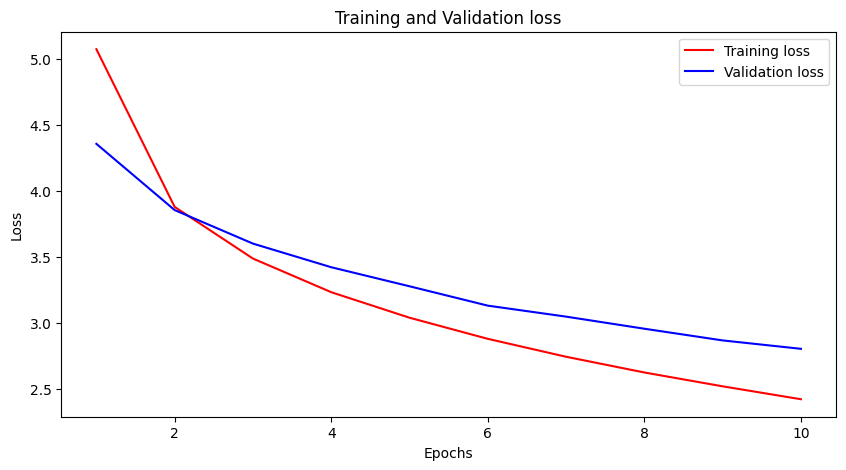

In [67]:
epochs = range(1, len(TrainLoss) + 1)

plt.figure(figsize=(10, 5))
plt.plot(epochs, TrainLoss, 'r', label='Training loss')
plt.plot(epochs,ValLoss, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Loading the saved model
If you want to skip training and load the pretrained model that is provided, go ahead and uncomment the following cell:


In [68]:
!wget 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMSkillsNetwork-AI0201EN-Coursera/transformer_de_to_en_model.pt'
transformer.load_state_dict(torch.load('transformer_de_to_en_model.pt',map_location=torch.device('cpu')))

/usr/bin/sh: 1: wget: not found


<All keys matched successfully>

## Translation and evaluation 
Using the greedy_decode function that you defined earlier, you can create a translator function that generates English translation of an input German text.


In [69]:
# translate input sentence into target language
def translate(model: torch.nn.Module, src_sentence: str):
    model.eval()
    src = text_transform[SRC_LANGUAGE](src_sentence).view(-1, 1)
    num_tokens = src.shape[0]
    src_mask = (torch.zeros(num_tokens, num_tokens)).type(torch.bool)
    tgt_tokens = greedy_decode(
        model,  src, src_mask, max_len=num_tokens + 5, start_symbol=BOS_IDX).flatten()
    return " ".join(vocab_transform[TGT_LANGUAGE].lookup_tokens(list(tgt_tokens.cpu().numpy()))).replace("<bos>", "").replace("<eos>", "")

Now, let's look into some sample translations:


In [70]:
for n in range(5):
    german, english= next(data_itr)

    print("German Sentence:",index_to_german(german).replace("<bos>", "").replace("<eos>", ""))
    print("English Translation:",index_to_eng(english).replace("<bos>", "").replace("<eos>", ""))
    print("Model Translation:",translate(transformer,index_to_german(german)))
    print("_________\n")

German Sentence:  Männer stehen neben irgendeiner hydraulischen Maschine . 
English Translation:  Men are standing next to some sort of hydraulic machine . 
Model Translation:  Men standing next to a basketball boat near the ocean near the ocean . 
_________

German Sentence:  Zwei Arbeiter reinigen nachts ein Bauwerk . 
English Translation:  Two workers are cleaning a structure at night . 
Model Translation:  Two workers are a small boy in a yellow shirt is pushing a bicycle down the ocean at night
_________

German Sentence:  Sieben Bauarbeiter arbeiten an einem Gebäude . 
English Translation:  Seven construction workers working on a building . 
Model Translation:  Construction workers working on a building working on a building working on a building . 
_________

German Sentence:  Die Kinder spielen nachts mit Wunderkerzen . 
English Translation:  The children play with sparklers at night . 
Model Translation:  The children are playing with a green umbrella of people with a few peop

### Evaluation with BLEU score
To evaluate the generated translations, a function calculate_bleu_score is introduced. It computes the BLEU score, a common metric for machine translation quality, by comparing the generated translation to reference translations. The BLEU score provides a quantitative measure of translation accuracy.

The code also includes an example of calculating the BLEU score for a generated translation.


In [71]:
def calculate_bleu_score(generated_translation, reference_translations):
    # convert the generated translations and reference translations into the expected format for sentence_bleu
    references = [reference.split() for reference in reference_translations]
    hypothesis = generated_translation.split()

    # calculate the BLEU score
    bleu_score = sentence_bleu(references, hypothesis)

    return bleu_score

In [72]:
generated_translation = translate(transformer,"Ein brauner Hund spielt im Schnee .")

reference_translations = [
    "A brown dog is playing in the snow .",
    "A brown dog plays in the snow .",
    "A brown dog is frolicking in the snow .",
    "In the snow, a brown dog is playing ."

]

bleu_score = calculate_bleu_score(generated_translation, reference_translations)
print("BLEU Score:", bleu_score, "for",generated_translation)

BLEU Score: 0.3252340343038979 for  A brown dog playing in the snow with a brown dog in the


## Exercise: Translating a document
In this exercise, you will implement a feature that translates a PDF in German to English. To achieve this, you will leverage the same sequence-to-sequence transformer model discussed previously and make necessary modifications.

1. **Define the translation function**:
   Create a function named `translate_pdf` that takes the following parameters:
   - `input_file`: The path to the input PDF file to be translated.
   - `translator_model`: A model or function that will handle the translation of text.
   - `output_file`: The path where the translated PDF will be saved.

2. **Read and translate the PDF**:
   Use `pdfplumber` to open and read the text from each page of the input PDF. Translate the extracted text using the `translator_model`.

3. **Format and write the translated text to a new PDF**:
   - Use `textwrap` to wrap the translated text so that it fits within the A4 page width.
   - Create a new PDF with `FPDF` and add the wrapped translated text to it.
   - Save the new PDF with the translated text to `output_file`.


In [73]:
import pdfplumber
import textwrap
from fpdf import FPDF

def translate_pdf(input_file, translator_model,output_file):
    translated_text = ""

    # Read the input PDF file
    with pdfplumber.open(input_file) as pdf:


        # Extract text from each page of the PDF
        for page in pdf.pages:
            text_content = page.extract_text()
            num_pages = len(pdf.pages)
            a4_width_mm = 210
            pt_to_mm = 0.35
            fontsize_pt = 10
            fontsize_mm = fontsize_pt * pt_to_mm
            margin_bottom_mm = 10
            character_width_mm = 7 * pt_to_mm
            width_text = a4_width_mm / character_width_mm

            pdf = FPDF(orientation='P', unit='mm', format='A4')
            pdf.set_auto_page_break(True, margin=margin_bottom_mm)
            pdf.add_page()
            pdf.set_font(family='Courier', size=fontsize_pt)
            # Split the text into sentences
            sentences = text_content.split(".")

            # Translate each sentence using the custom translator model
            for sentence in sentences:
                translated_sentence = translate(translator_model,sentence)
                lines = textwrap.wrap(translated_sentence, width_text)

                if len(lines) == 0:
                    pdf.ln()

                for wrap in lines:
                    pdf.cell(0, fontsize_mm, wrap, ln=1)

            pdf.output(output_file, 'F')

<details>
    <summary>Click here for Solution</summary>

```python
def translate_pdf(input_file, translator_model,output_file):
    translated_text = ""

    # Read the input PDF file
    with pdfplumber.open(input_file) as pdf:


        # Extract text from each page of the PDF
        for page in pdf.pages:
            text_content = page.extract_text()
            num_pages = len(pdf.pages)
            a4_width_mm = 210
            pt_to_mm = 0.35
            fontsize_pt = 10
            fontsize_mm = fontsize_pt * pt_to_mm
            margin_bottom_mm = 10
            character_width_mm = 7 * pt_to_mm
            width_text = a4_width_mm / character_width_mm

            pdf = FPDF(orientation='P', unit='mm', format='A4')
            pdf.set_auto_page_break(True, margin=margin_bottom_mm)
            pdf.add_page()
            pdf.set_font(family='Courier', size=fontsize_pt)
            # Split the text into sentences
            sentences = text_content.split(".")

            # Translate each sentence using the custom translator model
            for sentence in sentences:
                translated_sentence = translate(translator_model,sentence)
                lines = textwrap.wrap(translated_sentence, width_text)

                if len(lines) == 0:
                    pdf.ln()

                for wrap in lines:
                    pdf.cell(0, fontsize_mm, wrap, ln=1)

            pdf.output(output_file, 'F')
```

</details>


Here is a German document for you to convert


In [74]:
!wget 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMSkillsNetwork-AI0201EN-Coursera/input_de.pdf'

/usr/bin/sh: 1: wget: not found


Now call the translate_pdf for the German file as an input to the function and check the output file for the translated file.


In [76]:
input_file_path = "input_de.pdf"
output_file = 'output_en.pdf'
# Call the translate_pdf() defined earlier for the input file
translate_pdf(input_file_path, transformer,output_file)
print("Translated PDF file is saved as:", output_file)

Translated PDF file is saved as: output_en.pdf


<details>
    <summary>Click here for Solution</summary>

```python
input_file_path = "input_de.pdf"
output_file = 'output_en.pdf'
translate_pdf(input_file_path, transformer,output_file)
print("Translated PDF file is saved as:", output_file)
```

</details>


# Congratulations! You have completed the lab


## Authors

[Joseph Santarcangelo](https://author.skills.network/instructors/joseph_santarcangelo) has a Ph.D. in Electrical Engineering, his research focused on using machine learning, signal processing, and computer vision to determine how videos impact human cognition. Joseph has been working for IBM since he completed his PhD.

[Fateme Akbari](https://www.linkedin.com/in/fatemeakbari/) is a Ph.D. candidate in Information Systems at McMaster University with demonstrated research experience in Machine Learning and NLP.


## References
[Attention is all you need](https://papers.nips.cc/paper/2017/file/3f5ee243547dee91fbd053c1c4a845aa-Paper.pdf) paper.

[Language Translation with nn.Transformer and torchtext](https://pytorch.org/tutorials/beginner/translation_transformer.html) PyTorch tutorial


© Copyright IBM Corporation. All rights reserved.
